### Introduction
This notebook will serve as a demo and tutorial on how to use the celltx framework, and our multiscale approach, for computational modeling of cell therapies.

### Setup
1. Clone celltx (https://github.com/hbhargava7/celltx)

    In a terminal:
```
git clone https://github.com/hbhargava7/celltx.git
cd celltx
```

2. Install celltx so that it is accessible by the Python interpreter.

    In a terminal, still within the celltx repository directory
```
pip install .
```

3. Test the installation
```
python
> import celltx
```
Should run without error.

### Build an Initial Model
In this example, we will model simple anti-CD19 CAR-T cells in a 3-compartment organism system (tumor, circulation, normal).

We will build the model using only default celltx functionality.

The way we will build the model is by writing a `get_model(**kwargs)` function that returns a `celltx.model.Model` instance.

We set it up this way for modularity. We will use the `**kwargs` later when we want to pass some settings to the model building code, e.g. assumptions to include in the model architecture.

In [1]:
from celltx.model import Model

def get_model(**kwargs):
    """
    Model of anti-CD19 CAR-T cell therapy.
    
    Parameters
    ----------
    kwargs : dict
        Keyword arguments, not used in the initial implementation
        
    Returns
    -------
    celltx.model.Model
    """
    
    # Instantiate a model
    model = Model(name='anti-CD19 CAR-T cell therapy')
    
    # Add compartments to the model
    model.bio.add_compartment(name='normal')
    model.bio.add_compartment(name='circulation')
    model.bio.add_compartment(name='tumor')

    # Specify the compartment topology
    model.bio.link_compartments('normal', 'circulation')
    model.bio.link_compartments('tumor', 'circulation')
    
    # Add the tumor cells
    model.bio.add_cells(name='cd19+', compartment='tumor', growth_type='logistic')
    
    # Add the therapeutic cells (i.e. the CAR-T cells)
    model.bio.add_tx_cells(name='CAR-T', states=['activated'])
    
    # Get all the Tx cells state selectors
    unactivated = model.bio.get_tx_cellstate(name='CAR-T', state=[('activated', 0)])
    activated = model.bio.get_tx_cellstate(name='CAR-T', state=[('activated', 1)])
    
    # Get the selector for the tumor cells
    cd19_tumor = model.bio.get_cells('cd19+')
    
    # Define activation and unactivation functions for the CAR-T cells that governs how unactivated cells become activated and vice versa.
    k_activate = model.bio.constant('k_activate', 5)
    k_unactivate = model.bio.constant('k_unactivate', 1)

    model.bio.add_tx_state_linkage('CAR-T', unactivated, activated, func=k_activate*unactivated*cd19_tumor)
    model.bio.add_tx_state_linkage('CAR-T', activated, unactivated, func=k_unactivate*activated)
    
    # Define the daughter state for proliferation (this means that when any CAR-T cells mulltiply they yield an unactivated cell)
    model.bio.set_tx_cell_daughter_state('CAR-T', unactivated)
    
    # Define the killing of cd19 tumor cells by activated T cells
    model.bio.add_tx_cell_killtarget('CAR-T', cd19_tumor, [activated])

    # Build up the model
    model.sys = model.bio.compose()
    model.graph = model.sys.compose()
    model.ode = model.graph.compose_ode_system()
    model.ode.gen_ode_model()
    
    return model


In [2]:
# Call our function to get a model.
model = get_model()

Model "anti-CD19 CAR-T cell therapy" Instantiated.
celltx BioLayer: Adding a logistic growth term the cells.
celltx ODELayer: Successfully compiled self.f_model to C via njit.


/usr/local/lib/python3.8/site-packages/celltx/graphlayer/graphlayer.py:160: UserWarning: WARNING: used extremely hacked up protection clause to not subtract proliferation
  warn("WARNING: used extremely hacked up protection clause to not subtract proliferation")
/usr/local/lib/python3.8/site-packages/celltx/graphlayer/graphlayer.py:143: UserWarning: failed to get node selector for node [node].[cell].[cd19+].[normal]
  warn('failed to get node selector for node %s' % node)
/usr/local/lib/python3.8/site-packages/celltx/graphlayer/graphlayer.py:143: UserWarning: failed to get node selector for node [node].[cell].[cd19+].[circulation]
  warn('failed to get node selector for node %s' % node)


### Visualize the Constructed Model
It is very important to look at the model that celltx built from our biological specifications.
This is critical both because we want to make sure we didn't mess up, and also that celltx doesn't have a bug.

Specifically, we will look at:

1. Model differential equations, which we should inspect manually
2. Model arguments (i.e. the initial conditions and parameters). These don't have values yet, but we can make sure the right params exist.
3. Model graph, which is a representation of our system in the form of a directed graph

In [3]:
# We will use the built in functions in celltx to visualize this stuff
from IPython.display import display
model.ode.display_equations(display, substitute=True)
model.ode.display_args()
model.graph.write_graph_dotfile('graph.dot', inc_labels=False, display=True)

Eq(Derivative([node].[tx_cell].[CAR-T].[circulation].[[('activated', 0)]], t), -k_death*X_self - k_mig_circulation_to_normal*X_self - k_mig_circulation_to_tumor*X_self + k_mig_normal_to_circulation*[node].[tx_cell].[CAR-T].[normal].[[('activated', 0)]] + k_mig_tumor_to_circulation*[node].[tx_cell].[CAR-T].[tumor].[[('activated', 0)]] + k_proliferation*[node].[tx_cell].[CAR-T].[circulation].[[('activated', 1)]] + k_proliferation*X_self + k_unactivate*[node].[tx_cell].[CAR-T].[circulation].[[('activated', 1)]])

Eq(Derivative([node].[tx_cell].[CAR-T].[normal].[[('activated', 0)]], t), -k_death*X_self + k_mig_circulation_to_normal*[node].[tx_cell].[CAR-T].[circulation].[[('activated', 0)]] - k_mig_normal_to_circulation*X_self + k_proliferation*[node].[tx_cell].[CAR-T].[normal].[[('activated', 1)]] + k_proliferation*X_self + k_unactivate*[node].[tx_cell].[CAR-T].[normal].[[('activated', 1)]])

Eq(Derivative([node].[tx_cell].[CAR-T].[normal].[[('activated', 1)]], t), -k_death*X_self + k_mig_circulation_to_normal*[node].[tx_cell].[CAR-T].[circulation].[[('activated', 1)]] - k_mig_normal_to_circulation*X_self - k_unactivate*X_self)

Eq(Derivative([node].[tx_cell].[CAR-T].[circulation].[[('activated', 1)]], t), -k_death*X_self - k_mig_circulation_to_normal*X_self - k_mig_circulation_to_tumor*X_self + k_mig_normal_to_circulation*[node].[tx_cell].[CAR-T].[normal].[[('activated', 1)]] + k_mig_tumor_to_circulation*[node].[tx_cell].[CAR-T].[tumor].[[('activated', 1)]] - k_unactivate*X_self)

Eq(Derivative([node].[tx_cell].[CAR-T].[tumor].[[('activated', 0)]], t), -k_activate*[node].[cell].[cd19+].[tumor]*X_self - k_death*X_self + k_mig_circulation_to_tumor*[node].[tx_cell].[CAR-T].[circulation].[[('activated', 0)]] - k_mig_tumor_to_circulation*X_self + k_proliferation*[node].[tx_cell].[CAR-T].[tumor].[[('activated', 1)]] + k_proliferation*X_self + k_unactivate*[node].[tx_cell].[CAR-T].[tumor].[[('activated', 1)]])

Eq(Derivative([node].[tx_cell].[CAR-T].[tumor].[[('activated', 1)]], t), k_activate*[node].[cell].[cd19+].[tumor]*[node].[tx_cell].[CAR-T].[tumor].[[('activated', 0)]] - k_death*X_self + k_mig_circulation_to_tumor*[node].[tx_cell].[CAR-T].[circulation].[[('activated', 1)]] - k_mig_tumor_to_circulation*X_self - k_unactivate*X_self)

Eq(Derivative([node].[cell].[cd19+].[tumor], t), k_cell_prolif*X_self*(1 - X_self/k_cell_carrycap) - k_death*X_self - k_kill*[node].[tx_cell].[CAR-T].[tumor].[[('activated', 1)]]*X_self)

MODEL SPECIES (index | name | initial value)
0 | [node].[tx_cell].[CAR-T].[circulation].[[('activated', 0)]] | 0.00e+00
1 | [node].[tx_cell].[CAR-T].[normal].[[('activated', 0)]] | 0.00e+00
2 | [node].[tx_cell].[CAR-T].[normal].[[('activated', 1)]] | 0.00e+00
3 | [node].[tx_cell].[CAR-T].[circulation].[[('activated', 1)]] | 0.00e+00
4 | [node].[tx_cell].[CAR-T].[tumor].[[('activated', 0)]] | 0.00e+00
5 | [node].[tx_cell].[CAR-T].[tumor].[[('activated', 1)]] | 0.00e+00
6 | [node].[cell].[cd19+].[tumor] | 0.00e+00

MODEL PARAMETERS (index | name | value)
0 | k_mig_circulation_to_normal | 1.00e+01
1 | k_proliferation | 1.00e+01
2 | k_unactivate | 1.00e+00
3 | k_death | 5.00e+00
4 | k_mig_normal_to_circulation | 1.00e+01
5 | k_mig_tumor_to_circulation | 1.00e+01
6 | k_mig_circulation_to_tumor | 1.00e+01
7 | k_activate | 5.00e+00
8 | k_cell_carrycap | 1.00e+01
9 | k_cell_prolif | 1.00e+01
10 | k_kill | 1.00e+01


### Assign Initial Parameter Values
We need starting values for all the model species (i.e. how many of each cell type exist at t=0), and for all the parameters (11 parameters, as shown above). The values at this point are just placeholders.

Here are some refs where people in the cancer immunology space have fit somewhat similar models. These can help us get ballpark starting values.

1. Pillis et al., Cancer Research, 2005 ([https://pubmed.ncbi.nlm.nih.gov/16140967/](https://pubmed.ncbi.nlm.nih.gov/16140967/))
2. Sahoo et al. J R Soc Interface, 2020 ([https://pubmed.ncbi.nlm.nih.gov/31937234/](https://pubmed.ncbi.nlm.nih.gov/31937234/))

In [4]:
# Get all the dependencies we're going to need.
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('dark_background')

In [5]:
# Only two species have nonzero values at t=0
model.ode.set_initial_value(0, 1e6) # Initial CAR-T cell population (unactivated)
model.ode.set_initial_value(6, 10e6) # Initial tumor cell population

# All migration coefficients are the same.
k_mig = 3.57e-2
model.ode.set_param_value('k_mig_circulation_to_normal', k_mig)
model.ode.set_param_value('k_mig_normal_to_circulation', k_mig)
model.ode.set_param_value('k_mig_tumor_to_circulation', k_mig)
model.ode.set_param_value('k_mig_circulation_to_tumor', k_mig)

# Logistic growth parameters for the tumor cells
model.ode.set_param_value('k_cell_carrycap', 1.02e9)
model.ode.set_param_value('k_cell_prolif', 5.14e-1)

model.ode.set_param_value('k_activate', 3.75e-2)
model.ode.set_param_value('k_unactivate', 2.00e-2)

model.ode.set_param_value('k_proliferation', 10e-2)
model.ode.set_param_value('k_death', 0.1e-5)

model.ode.set_param_value('k_kill', 6e-9)

### Simulate the model
Use numerical integration to evaluate the model given its architecture, initial conditions, and parameters.

/usr/local/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Title: [node].[tx_cell].[CAR-T].[circulation].[[('activated', 0)]]


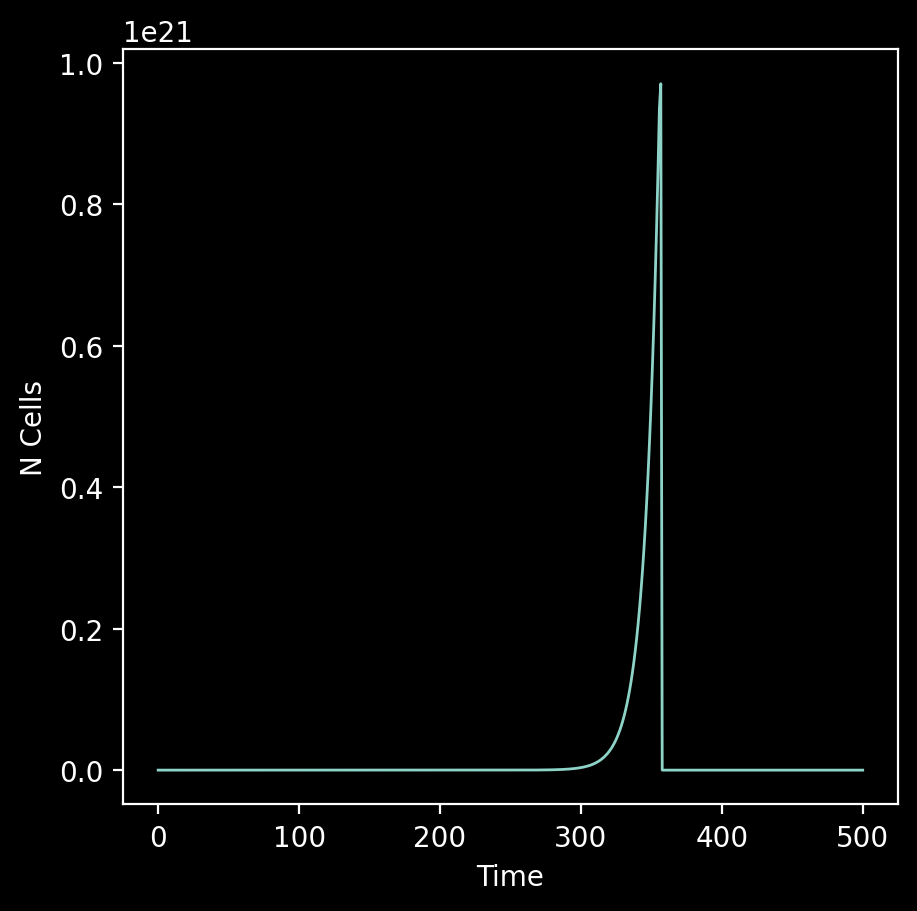

Title: [node].[tx_cell].[CAR-T].[normal].[[('activated', 0)]]


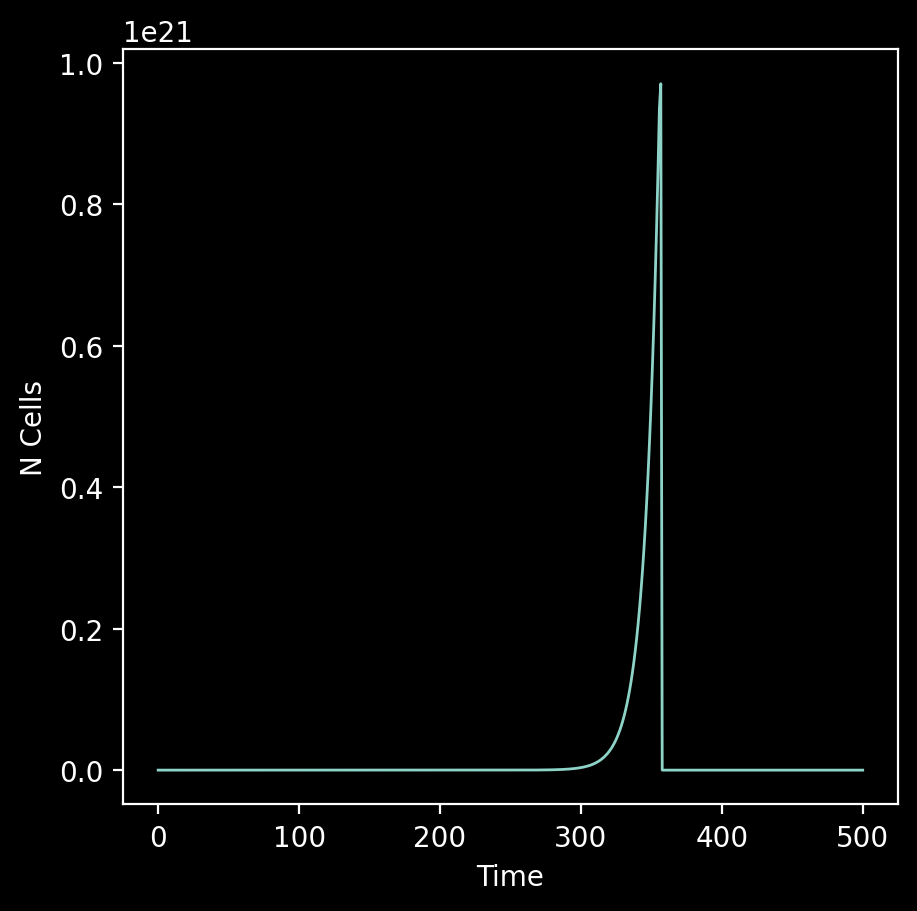

Title: [node].[tx_cell].[CAR-T].[normal].[[('activated', 1)]]


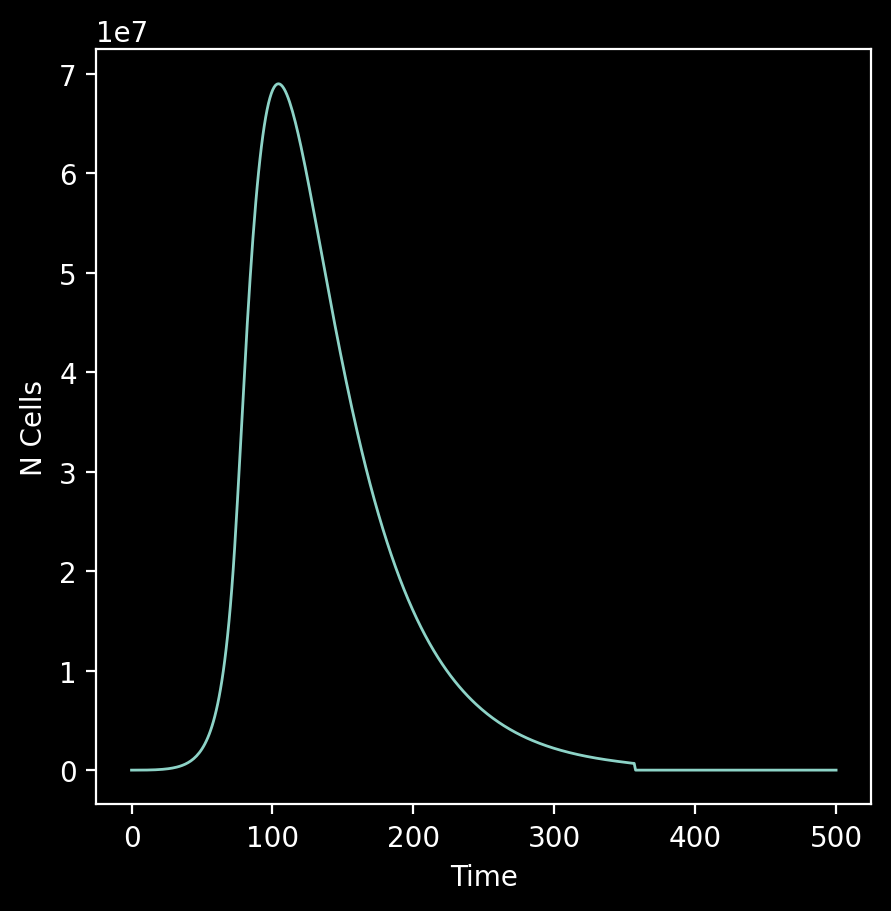

Title: [node].[tx_cell].[CAR-T].[circulation].[[('activated', 1)]]


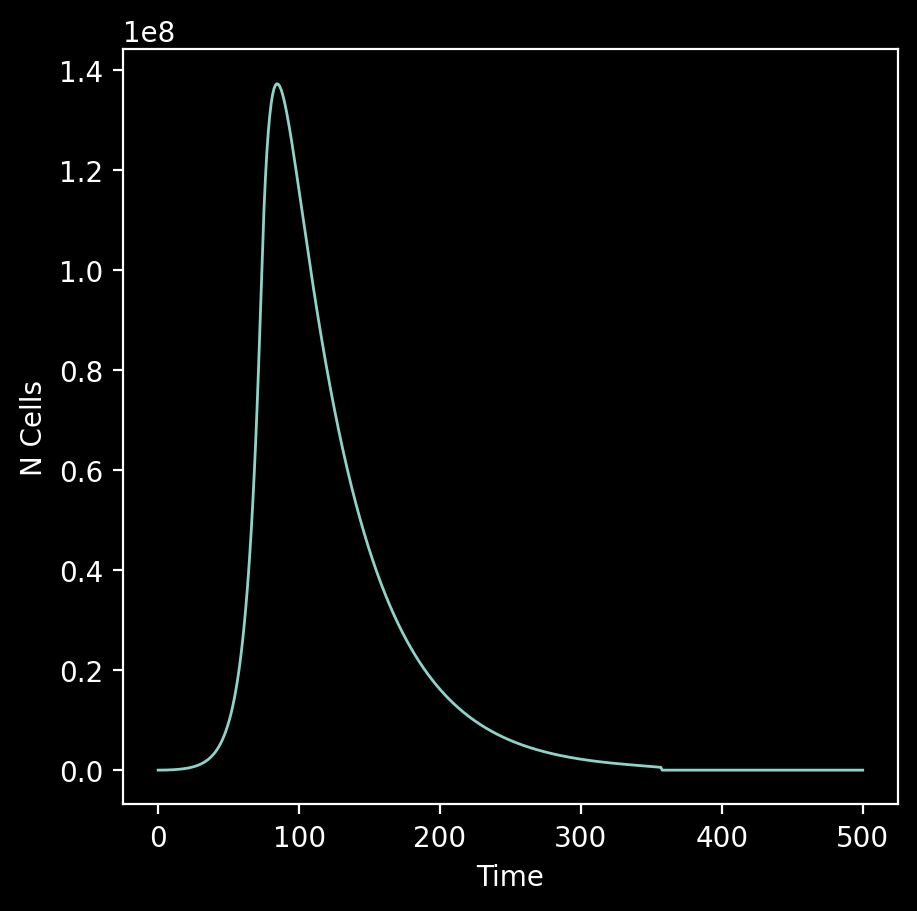

Title: [node].[tx_cell].[CAR-T].[tumor].[[('activated', 0)]]


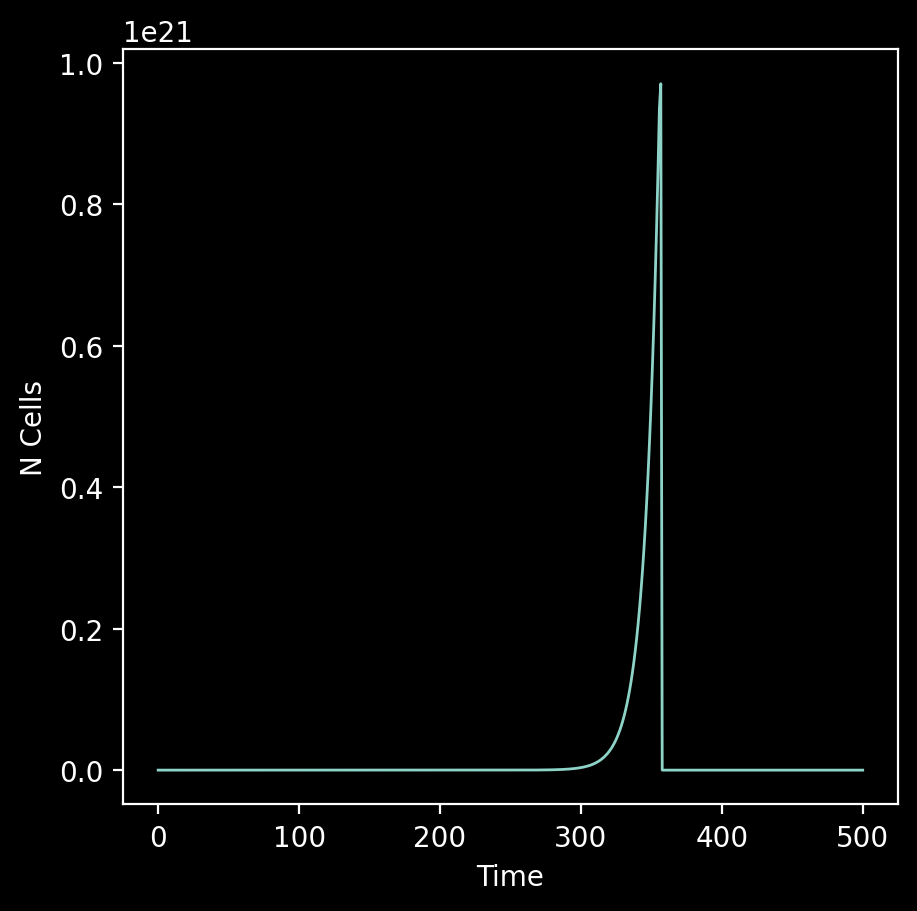

Title: [node].[tx_cell].[CAR-T].[tumor].[[('activated', 1)]]


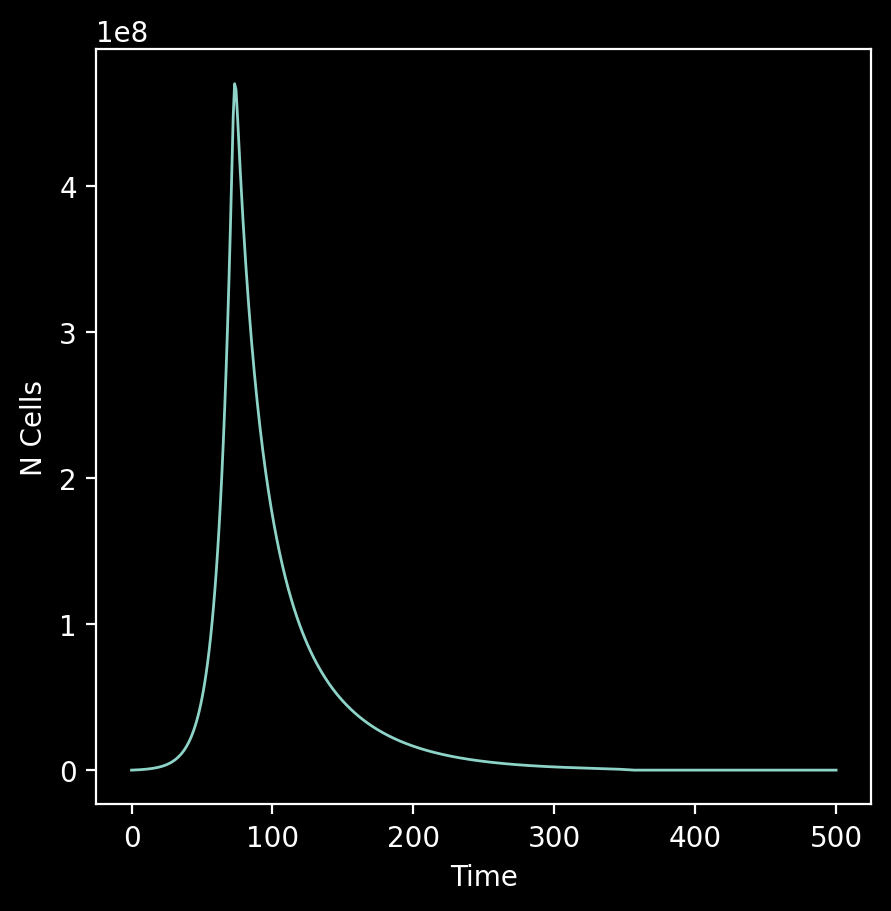

Title: [node].[cell].[cd19+].[tumor]


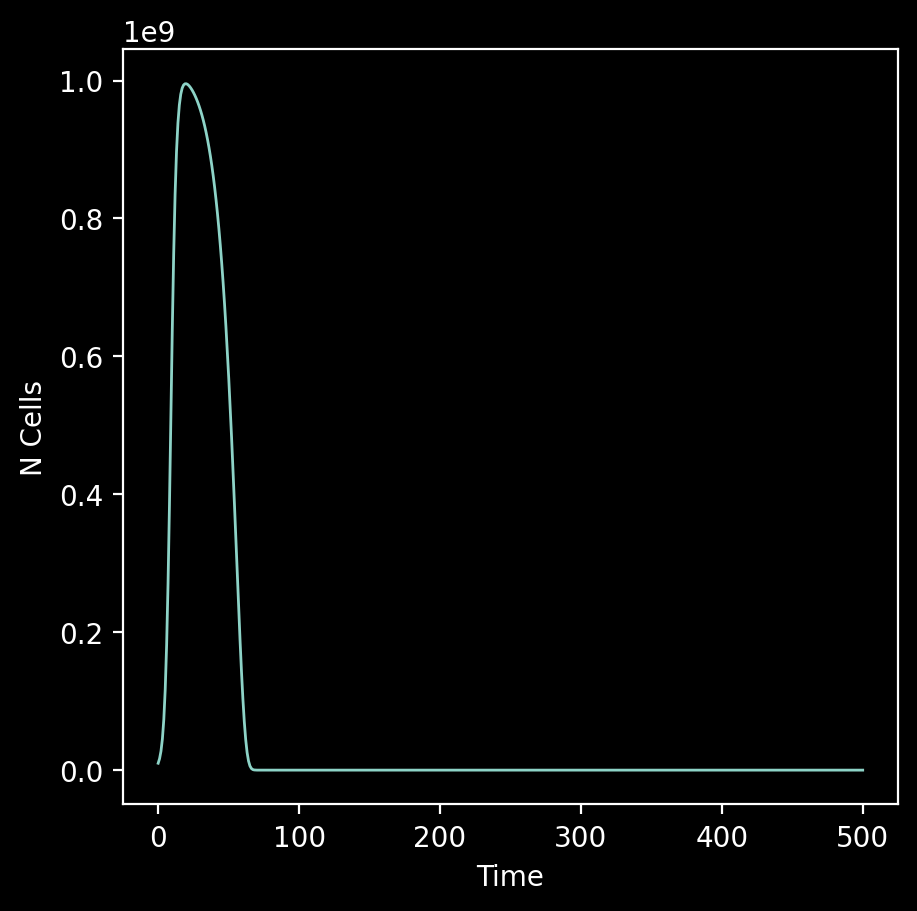

In [6]:
t = np.linspace(0, 500, 500)

x = model.ode.integrate(t)

for i in range(x.shape[1]):
    plt.figure(figsize =(5,5), dpi=100) 
    print("Title: %s" % model.ode.species[i])
    plt.plot(t,x[:,i],linewidth=1)
    plt.xlabel('Time')
    plt.ylabel('N Cells')
    plt.show()